# Purpose

Learning more about NN's with the MNIST challenge

## To do

~~Normalization of the data~~

Augmentation of the data

Implement early stopping

Try dropout layer

Confusion matrix to find out what errors are made

In [1]:
#Import packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2023-09-20 11:49:17.834924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Load data
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
#Separate target from training set. No missing data
y_train = train0['label']
train1 = train0.drop(labels=['label'], inplace=False, axis = 1)

In [4]:
#Possibly augment the data

In [5]:
#Possibly normalize
scaler = StandardScaler()
train2 = scaler.fit_transform(train1)
test1 = scaler.fit_transform(test0)

In [6]:
#Split the training data into test and validation set
X_train, X_val, y_train, y_val = train_test_split(train2, y_train, test_size=0.2, random_state=42)
X_train_reshaped = np.reshape(X_train, (-1, 28, 28, 1))
X_val_reshaped = np.reshape(X_val, (-1, 28, 28, 1))
test1_reshaped = np.reshape(test1, (-1, 28, 28, 1))


In [7]:
#Multinomal logistic regression as a baseline, accuracy on validation set ~0.9
#clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

In [8]:
#Score the logistic regression model
#clf.score(X_val,y_val)

In [9]:
#Building a convolutional neural network
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(Dropout(0.5))  # 50% dropout rate
model.add(Flatten())
model.add(Dense(units=10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 10)                216330    
                                                                 
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


2023-09-20 11:49:33.747412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=10, 
                    validation_data=(X_val_reshaped, y_val))

Epoch 1/10
1050/1050 [==============================] - 7s 7ms/step - loss: 0.2577 - accuracy: 0.9262 - val_loss: 0.1383 - val_accuracy: 0.9606
Epoch 2/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.1164 - accuracy: 0.9662 - val_loss: 0.1090 - val_accuracy: 0.9692
Epoch 3/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0839 - accuracy: 0.9737 - val_loss: 0.0932 - val_accuracy: 0.9737
Epoch 4/10
1050/1050 [==============================] - 7s 6ms/step - loss: 0.0660 - accuracy: 0.9788 - val_loss: 0.0933 - val_accuracy: 0.9749
Epoch 5/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0600 - accuracy: 0.9811 - val_loss: 0.0973 - val_accuracy: 0.9736
Epoch 6/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0483 - accuracy: 0.9842 - val_loss: 0.1031 - val_accuracy: 0.9727
Epoch 7/10
1050/1050 [==============================] - 6s 6ms/step - loss: 0.0459 - accuracy: 0.9861 - val_loss: 0.1009 - val_accuracy:

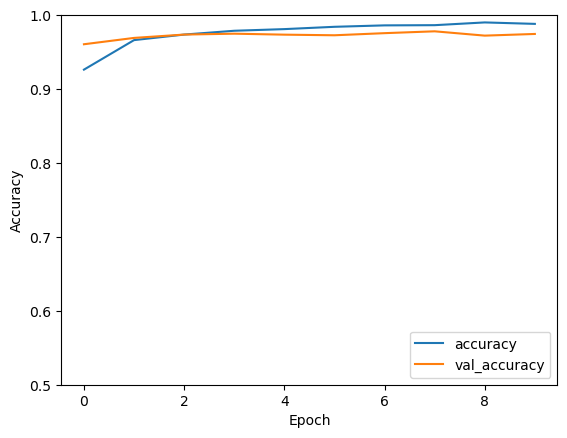

Validation Loss: 0.1179
Validation Accuracy: 97.45%


In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

loss, accuracy = model.evaluate(X_val_reshaped, y_val, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

263/263 [==============================] - 1s 2ms/step


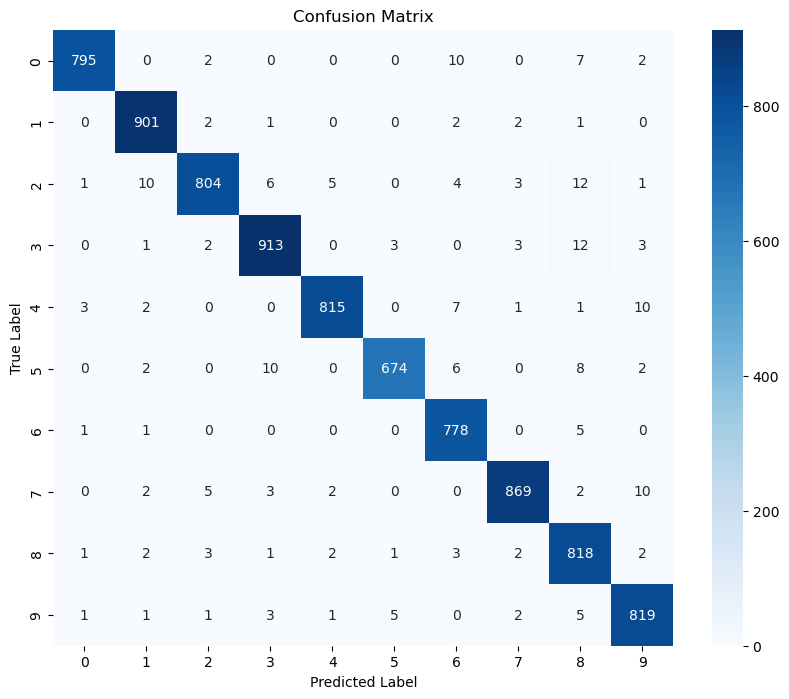

In [12]:
#Confusion matrix
probabilities_val = model.predict(X_val_reshaped)
predicted_val_labels = np.argmax(probabilities_val, axis=1)
cm = confusion_matrix(y_val, predicted_val_labels)

# Display using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#8's and 7's are most often mistaken, intersstingly enough both for 2's. If we look to expand the dataset,
#that is probably where we should focus our efforts.

In [13]:
#Predictions for test set
probabilities_test = model.predict(test1_reshaped)
predicted_labels_test = np.argmax(probabilities_test, axis=1)

875/875 [==============================] - 2s 2ms/step


In [16]:
image_ids = np.arange(1, len(predicted_labels_test) + 1)
df = pd.DataFrame({'ImageId': image_ids, 'Label': predicted_labels_test})

In [18]:
df.to_csv('./Submissions/001_submission.csv', index=False, header=True)

## Perfomance

### 000
Comment: CNN, two layers

Score: 0.97107

### 001
Comment: CNN, added dropout layer

Score: 0.97389